In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

In [3]:
target_file_dir = "../../datas/"
target_file_names = [
    "RealEstateData_20111_20164_13_main",
    "RealEstateData_20171_20234_13_main",
    "RealEstateData_20111_20234_14_main"
]
target_file_end = ".csv"
df_origin = pd.DataFrame()
for file_name in target_file_names:
    df = pd.read_csv(target_file_dir + file_name + target_file_end)
    df_origin = pd.concat([df_origin, df], axis=0)

In [6]:
df_origin.Type.unique()

array(['宅地(土地と建物)', '中古マンション等'], dtype=object)

In [11]:
print(df_origin.shape)
print(df_origin.columns)
print(df_origin.isnull().sum())

(451808, 16)
Index(['TradeNo', 'Type', 'Prefecture', 'Municipality', 'DistrictName',
       'Structure', 'FloorPlan', 'TradePrice', 'AgeAtTrade', 'Area',
       'TotalFloorArea', 'CoverageRatio', 'FloorAreaRatio', 'BuildingYearW',
       'TradeYear', 'TradeQuarter'],
      dtype='object')
TradeNo                0
Type                   0
Prefecture             0
Municipality           0
DistrictName         444
Structure          18304
FloorPlan         206699
TradePrice             0
AgeAtTrade         18208
Area                   0
TotalFloorArea    263472
CoverageRatio       6038
FloorAreaRatio      6038
BuildingYearW      18208
TradeYear              0
TradeQuarter           0
dtype: int64


In [78]:
# パラメータ
TradePriceThrethold = 15000
AgeAtTradeThrethold = 50
select_type = "宅地(土地と建物)" #宅地(土地と建物) 中古マンション等
# prefecture = "東京都"
use_cols_noncategory = ["TradePrice","Area","TradeYear","AgeAtTrade"] #Municipality Prefecture
category_cols = ['Municipality']
use_cols = use_cols_noncategory + category_cols
AreaThrethold = 300 if select_type == "宅地(土地と建物)" else 100 if select_type == "中古マンション等" else 0

# データ読み込み
col_choice_extract = (~df_origin.AgeAtTrade.isnull())&(df_origin.Type==select_type)#&(df_origin.Prefecture==prefecture)
col_choice_threthold = (df_origin.TradePrice<TradePriceThrethold)&(df_origin.Area<AreaThrethold)&(df_origin.AgeAtTrade<AgeAtTradeThrethold)
df_base = df_origin.loc[col_choice_extract&col_choice_threthold,use_cols].copy()
print(df_origin.shape[0], df_origin.loc[col_choice_extract,:].shape[0],df_base.shape[0])


451808 186498 170972


Coefficients: {'Area': 20.4578494715531, 'TradeYear': 85.26563537584993, 'AgeAtTrade': -57.41848678581118, 'あきる野市': -1964.8777345272429, '三宅村': -5521.751965027436, '三浦市': -2014.677802228828, '三浦郡葉山町': -611.5102691388265, '三鷹市': 1651.9284675201814, '世田谷区': 3818.049323621791, '中央区': 5778.644631171601, '中郡二宮町': -1908.5138044326095, '中郡大磯町': -1669.5030255146312, '中野区': 2832.169057178563, '伊勢原市': -1736.5187374833235, '八丈町': -4630.566492989373, '八王子市': -1161.2917899428621, '北区': 1984.4622925731132, '千代田区': 5795.619512440395, '南足柄市': -2448.480432357553, '厚木市': -1357.241664649714, '台東区': 3326.5807180838715, '品川区': 3431.3241164994297, '国分寺市': 771.4022229479892, '国立市': 1044.488628516424, '墨田区': 1824.086208472321, '多摩市': -122.88797202009891, '大和市': -187.2839978194619, '大島町': -4285.0371685109785, '大田区': 2709.9171044682844, '小平市': 239.99832045551148, '小田原市': -1777.7014126747413, '小笠原村': -1339.99451817634, '小金井市': 1193.036627442721, '川崎市中原区': 2026.0720336208697, '川崎市多摩区': 598.4720194710825, '川崎市宮前区'

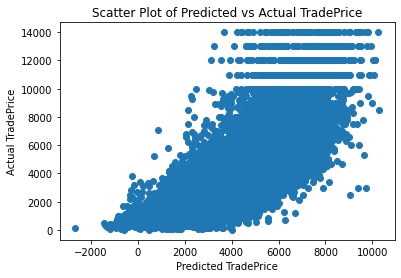

In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# データ読み込み
# df = pd.read_csv('your_data.csv')  # データがCSVファイルから読み込まれる場合

# Prefecture列をOne-Hotエンコーディングして新しい列を作成
df = df_base.copy()
category_col_counts = []
for category_col in category_cols:
    df = pd.get_dummies(df, columns=[category_col])
    df.columns = df.columns.str.split('_').str[-1] #prefixを除去
    category_col_counts.append(len(df_base[category_col].unique()))

# 被説明変数と説明変数に分割
X = df.drop('TradePrice', axis=1)
y = df['TradePrice']

# データの正規化
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_normalized=X

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# 重回帰分析モデルの構築
model = LinearRegression()
model.fit(X_train, y_train)

# モデルの評価（絶対値誤差）
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

# 係数と切片の表示
coefficients = dict(zip(X.columns, model.coef_))
intercept = model.intercept_

print('Coefficients:', coefficients)
print('Intercept:', intercept)

# MAEの表示
print('Mean Absolute Error:', mae)

# テストデータの結果をグラフ化
# for column in X.columns:
#     plt.scatter(X_test[:, X.columns.get_loc(column)], y_test, label='Actual')
#     plt.scatter(X_test[:, X.columns.get_loc(column)], y_pred, label='Predicted')
#     plt.xlabel(column)
#     plt.ylabel('TradePrice')
#     plt.legend()
#     plt.show()

# 予測をx軸、正解をy軸とした散布図
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted TradePrice')
plt.ylabel('Actual TradePrice')
plt.title('Scatter Plot of Predicted vs Actual TradePrice')
plt.show()


In [71]:
# 説明変数とその切片の値を、記録
# categoryをdummy化したものと、そうでないものでdfを分ける。
df_coef = pd.DataFrame(
    [X.columns, model.coef_],
    index=['col_name', 'coef']
    ).T
df_coef['Type'] = select_type

start_category_col = len(use_cols_noncategory)-1
df_coef_noncate = df_coef.iloc[:start_category_col,:].copy()
df_coef_noncate = df_coef_noncate.loc[:,['Type', 'col_name', 'coef']]


df_coef_cate = df_coef.iloc[start_category_col:,:].copy()

df_coef_cate['col_name_value'] = df_coef_cate.col_name
now_col = 0
for i, category_col in enumerate(category_cols):
    next_col = now_col + category_col_counts[i] 
    df_coef_cate.iloc[now_col:next_col,0]= category_col
    now_col = next_col
df_coef_cate = df_coef_cate.loc[:,['Type','col_name_value', 'col_name', 'coef']]
df_coef_cate

df_coef_noncate.to_csv('../../datas/RealEsateData_重回帰切片_noncate_' + select_type + '.csv', index=False)
df_coef_cate.to_csv('../../datas/RealEsateData_重回帰切片_cate_' + select_type + '.csv', index=False)

In [58]:
next_col

2

In [16]:
import pandas as pd

# サンプルデータを作成
data = {
    'Category1': ['A', 'B', 'A', 'C', 'B'],
    'Category2': ['X', 'Y', 'X', 'Z', 'Z']
}

df = pd.DataFrame(data)

# prefixを指定せずにダミー変数を生成
df_dummies = pd.get_dummies(df, prefix='')

# 結果を表示
print(df_dummies)

      _A     _B     _C     _X     _Y     _Z
0   True  False  False   True  False  False
1  False   True  False  False   True  False
2   True  False  False   True  False  False
3  False  False   True  False  False   True
4  False   True  False  False  False   True


In [48]:
max(y)

14000.0